dataset taken from https://archive.ics.uci.edu/ml/datasets/Epileptic%2BSeizure%2BRecognition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
import keras

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
main = pd.read_csv('data.csv')
main.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


Class 5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

Class 4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed

Class 3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

Class 2 - They recorder the EEG from the area where the tumor was located

Class 1 - Recording of seizure activity

In [4]:
main.isnull().sum().sum()

0

In [5]:
classes = main.groupby('y').size()
classes

y
1    2300
2    2300
3    2300
4    2300
5    2300
dtype: int64

### Balanced dataset

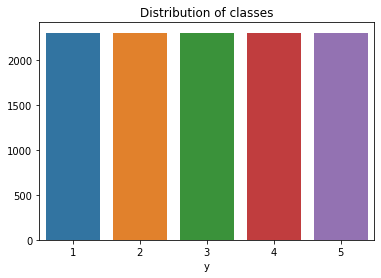

In [6]:
sns.barplot(x=classes.index,y=classes.values)
plt.title('Distribution of classes')
plt.show()

### Interpreting the name tag of each dataset

In [7]:
names=main[['Unnamed: 0']]

In [8]:
names['X']=names['Unnamed: 0'].str.split('.').apply(lambda x: x[0])

In [9]:
names

,Unnamed: 0,X
0,X21.V1.791,X21
1,X15.V1.924,X15
2,X8.V1.1,X8
3,X16.V1.60,X16
4,X20.V1.54,X20
...,...,...
11495,X22.V1.114,X22
11496,X19.V1.354,X19
11497,X8.V1.28,X8
11498,X10.V1.932,X10


In [10]:
names['V']=names['Unnamed: 0'].str.split('.').apply(lambda x: x[1])

In [11]:
names['Unnamed: 0'].str.split('.').iloc[0][2]

'791'

In [12]:
def get_element(my_list, position):
    try: x= my_list[position]
    except: x = 'Missing'
    return x

In [13]:
names['num#']=names['Unnamed: 0'].str.split('.').apply(get_element, position=2)

In [14]:
patient=pd.concat([names,classes], axis=1)
patient.head()

,Unnamed: 0,X,V,num#,0
0,X21.V1.791,X21,V1,791,NaN
1,X15.V1.924,X15,V1,924,2300.0
2,X8.V1.1,X8,V1,1,2300.0
3,X16.V1.60,X16,V1,60,2300.0
4,X20.V1.54,X20,V1,54,2300.0


In [15]:
patient['V'].unique()

array(['V1', 'V14', 'V12', 'V13', 'V11'], dtype=object)

In [16]:
patient['X'].unique() #X1-X23

array(['X21', 'X15', 'X8', 'X16', 'X20', 'X14', 'X3', 'X11', 'X19', 'X7',
       'X1', 'X22', 'X9', 'X23', 'X18', 'X2', 'X12', 'X5', 'X10', 'X13',
       'X4', 'X17', 'X6'], dtype=object)

### Each of the patient's brain wave of 4097points split into 23 chunks. each chunk has 178points (hence X1~X178 of each sample)

115 missing data comes from 5 patients (23*5 = 115)

In [17]:
patient['num#'].value_counts()

Missing    115
791         23
89          23
911         23
631         23
          ... 
641         23
50          23
694         23
102         23
903         23
Name: num#, Length: 496, dtype: int64

In [18]:
patient['V'].unique()

array(['V1', 'V14', 'V12', 'V13', 'V11'], dtype=object)

In [19]:
patient[(patient['num#']=='Missing')&(patient['V']=='V13')]

,Unnamed: 0,X,V,num#,0
420,X10.V13,X10,V13,Missing,NaN
879,X4.V13,X4,V13,Missing,NaN
1437,X15.V13,X15,V13,Missing,NaN
1928,X12.V13,X12,V13,Missing,NaN
2640,X21.V13,X21,V13,Missing,NaN
2768,X16.V13,X16,V13,Missing,NaN
5780,X2.V13,X2,V13,Missing,NaN
6506,X6.V13,X6,V13,Missing,NaN
7150,X1.V13,X1,V13,Missing,NaN
7184,X20.V13,X20,V13,Missing,NaN


In [20]:
patient['num#'].unique()[:10]

array(['791', '924', '1', '60', '54', '56', '191', '273', '874', '491'],
      dtype=object)

In [21]:
patient[patient['num#']=='491']

,Unnamed: 0,X,V,num#,0
9,X3.V1.491,X3,V1,491,NaN
587,X21.V1.491,X21,V1,491,NaN
1191,X7.V1.491,X7,V1,491,NaN
2019,X9.V1.491,X9,V1,491,NaN
2086,X23.V1.491,X23,V1,491,NaN
2774,X16.V1.491,X16,V1,491,NaN
3157,X12.V1.491,X12,V1,491,NaN
3313,X8.V1.491,X8,V1,491,NaN
3660,X22.V1.491,X22,V1,491,NaN
4051,X14.V1.491,X14,V1,491,NaN


### Conclusion

total samples = 11500 = 500 x 23

there are 500 patients, each contribute 23chunks of 178 timesteps.

Each patient belongs to only one of the 5 classes. i.e. the patient is told to stay close/open his eye during the entire EEG scan



### 2) Visualization of EEG

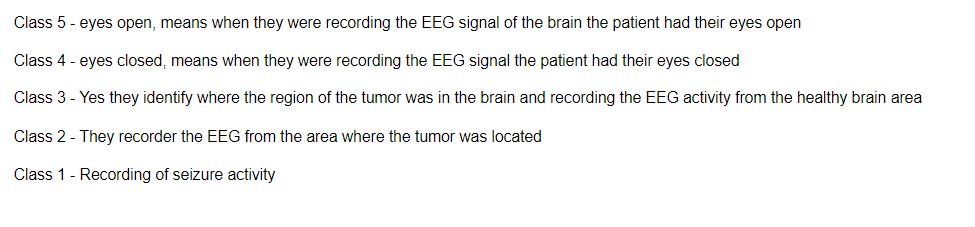

In [22]:
classes_type = ['Seizure','tumor near','tumor far','eyes close','eyes open']

In [23]:
display_sample_index = []

In [24]:
np.random.seed(123)

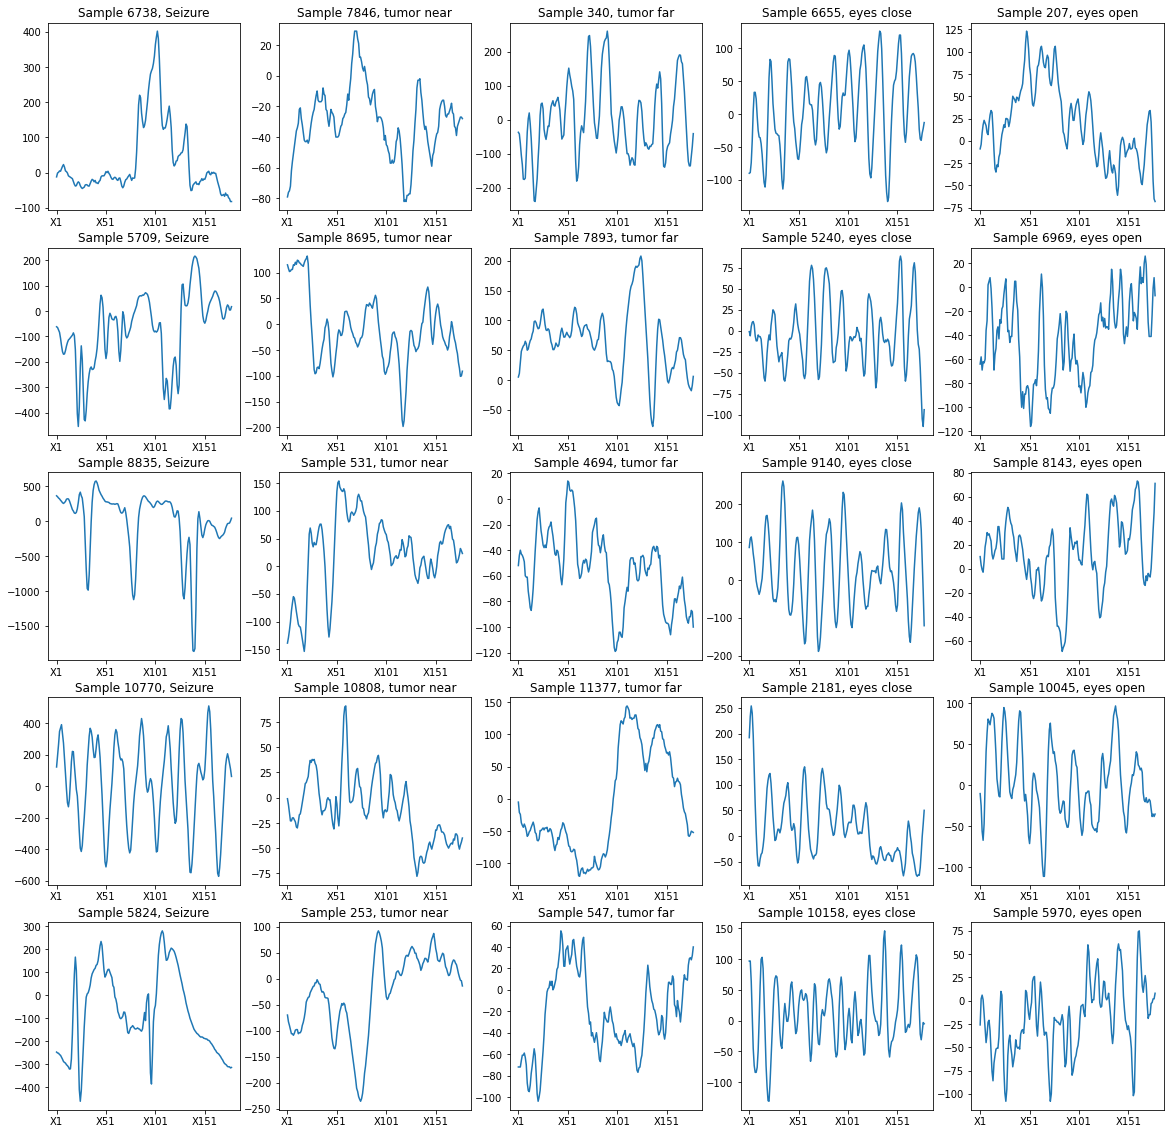

In [25]:
import warnings
warnings.filterwarnings('ignore')

f, axes = plt.subplots(5,5, figsize=(20, 20))
for j in range(0,5):
    classs = main[main['y'] == j+1]
    EEG = classs.drop(columns = ['Unnamed: 0','y'])
    index_ = []
    #transpose
    EEG_T = EEG.T
    for col in range (0,5):
        x = np.random.randint(0, 2299)
        index_.append(x)
        
        ax3=EEG_T[EEG_T.columns[x]].plot(kind='line',ax=axes[col,j], 
                                       title = 'Sample '+str(EEG_T.columns[x])+', '+classes_type[j])
    display_sample_index.append(index_)
        
    
        



In [26]:
display_sample_index

[[1346, 1122, 1766, 2154, 1147],
 [1593, 1761, 96, 2161, 47],
 [73, 1568, 942, 2272, 111],
 [1363, 1092, 1847, 451, 2050],
 [39, 1346, 1583, 1981, 1159]]

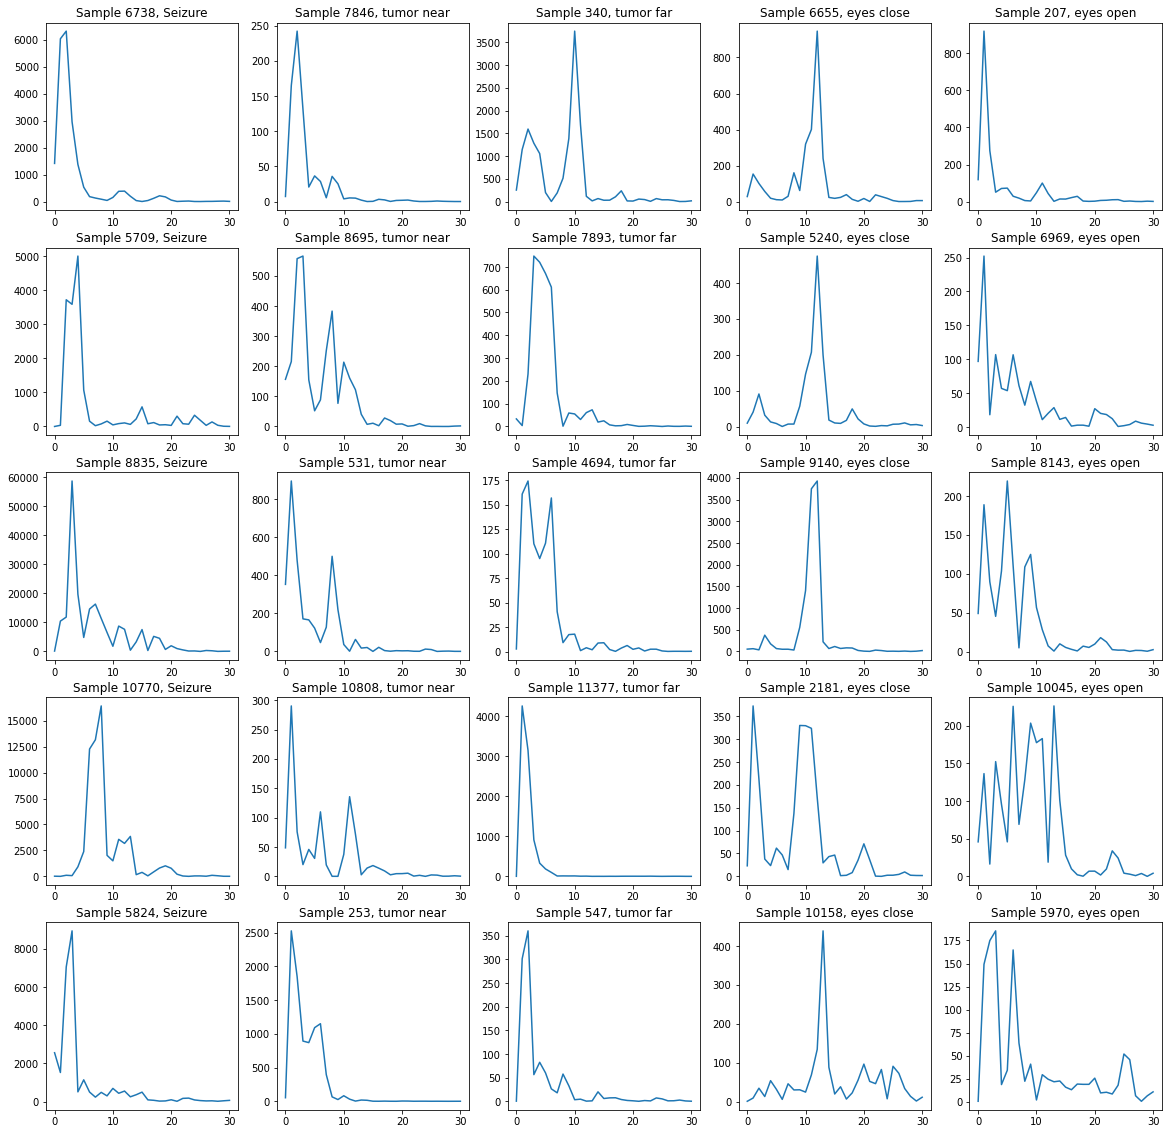

In [27]:
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
sf = 178

f, axes = plt.subplots(5,5, figsize=(20, 20))
for j in range(0,5):
    classs = main[main['y'] == j+1]
    EEG = classs.drop(columns = ['Unnamed: 0','y'])
    
    #transpose
    EEG_T = EEG.T
    for col in range (0,5):
        x = display_sample_index[j][col]
        freqs, psd = signal.welch(EEG_T[EEG_T.columns[x]], sf, nperseg=sf)
        axes[col,j].plot(freqs[:31], psd[:31])
        axes[col,j].set_title('Sample '+str(EEG_T.columns[x])+', '+classes_type[j])
        
    


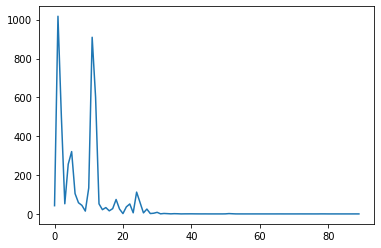

In [28]:
from scipy import signal
EEG = main.drop(columns = ['Unnamed: 0','y'])
EEG_T = EEG.T
sf = 178
freqs, psd = signal.welch(EEG_T[EEG_T.columns[1222]], sf, nperseg=sf)

plt.plot(freqs, psd)
plt.show()


Delta wave 0~4 Hz

Tetha wave 4~8 Hz

Beta wave 8~12 Hz

Alpha wave 12~30Hz

In [29]:
def extract_xy_time(main):
    EEG_all = main.drop(columns = ['Unnamed: 0','y'])
    X = np.array(EEG_all)
    X = X.reshape(11500,178,1)
    label = main['y']

    y = np.array(label).reshape(-1,1)
    return X,y


In [30]:
def psd_diffwaves(psd,f):
    psd_delta = f(psd[0:4])
    psd_tetha = f(psd[4:8])
    psd_alpha = f(psd[8:12])
    psd_beta = f(psd[12:30])
    return psd_delta,psd_tetha, psd_alpha,psd_beta

In [31]:
def time_to_freq(X,limit=90):
    from scipy import signal
    X = X.reshape(11500,178)
    X_transform = []
    for i in range(X.shape[0]):
        sf = X.shape[1]
        freqs, psd = signal.welch(X[i], sf, nperseg=sf)
        X_transform.append(psd[:limit])
    
    X_transform = np.array(X_transform)
    X_transform = X_transform.reshape(11500,limit,1)
    return X_transform

In [32]:
X,y = extract_xy_time(main)

In [33]:
X_transform = time_to_freq(X)

In [34]:
X_transform.shape

(11500, 90, 1)

In [35]:
delta = np.empty(11500)
tetha = np.empty(11500)
beta = np.empty(11500)
alpha = np.empty(11500)

In [36]:
for i in range(X_transform.shape[0]):
    delta[i], tetha[i], beta[i],alpha[i]= psd_diffwaves(X_transform[i],f=np.median)

In [37]:
wave_EDA = pd.DataFrame({'delta':delta,'tetha':tetha,'alpha':alpha,'beta':beta,'class':y.reshape(1,-1)[0]})

In [38]:
wave_EDA

,delta,tetha,alpha,beta,class
0,715.618997,45.249995,57.297728,36.809778,4
1,18787.506720,18856.978592,1118.124329,6435.683643,1
2,91.621848,76.144484,13.134380,73.765446,5
3,20.492839,7.232371,2.268499,12.686275,5
4,60.452812,33.123341,10.496218,24.306473,5
...,...,...,...,...,...
11495,116.866106,122.694935,0.507589,10.206185,2
11496,117.292537,3034.921683,80.319408,938.421172,1
11497,102.962491,20.227059,21.821350,6.112830,5
11498,27.394787,61.991969,8.715527,281.190019,3


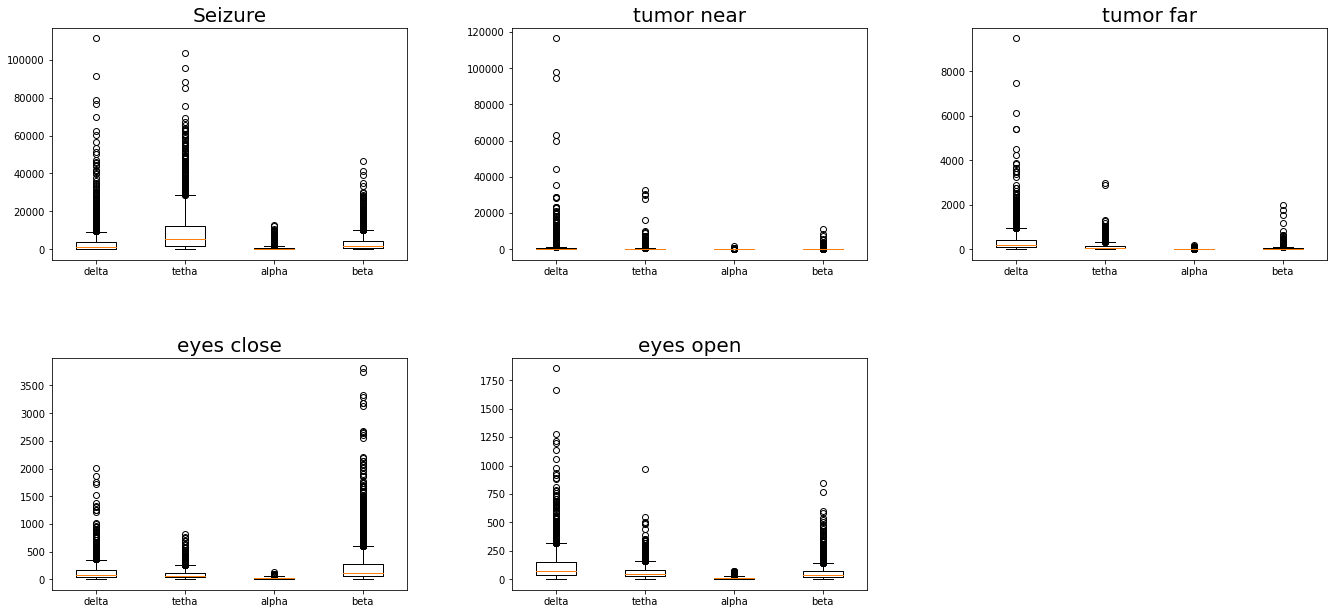

In [39]:
f, axes = plt.subplots(2,3, figsize=(20, 10))
i=1

for row in range(2):  
      
    for col in range (3):
        if i==6:
            
            axes[row,col].set_visible(False) #there are only 5 graph, the last will be blank
            break       
        
        w=wave_EDA[wave_EDA['class']==i]
        axes[row,col].set_title(classes_type[i-1],fontsize=20)
        ax=axes[row,col].boxplot([w['delta'],w['tetha'],w['alpha'],w['beta']])
        
        i=i+1
plt.setp(axes, xticks=[1,2,3,4], xticklabels=['delta','tetha','alpha','beta'])
f.tight_layout(pad = 6)
plt.show()

### Machine Learning

In [40]:
def split(X,y):    
    trainX, testX, trainy, testy = train_test_split(X,y,test_size = 0.3,stratify=y,random_state=123)
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    return trainX, testX, trainy, testy

In [41]:
def lstm(trainX, testX, trainy, testy): 
    
    # fit and evaluate a model
    verbose, epochs, batch_size = 1, 100, 50
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features))) #input diff from normal NN
    model.add(Dropout(0.5)) #.2, .3
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
    
    # fit network
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, 
                        validation_data=(trainX, trainy))
    # evaluate model
    score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    print('Accuracy :',score[1])
    return model, history


In [42]:
X,y = extract_xy_time(main)

In [43]:
trainX, testX, trainy, testy = split(X,y)

In [44]:
%%time
model_1, history = lstm(trainX, testX, trainy, testy)

Epoch 1/100
161/161 [==============================] - 14s 24ms/step - loss: 1.2449 - accuracy: 0.4402 - val_loss: 0.9515 - val_accuracy: 0.5794
Epoch 2/100
161/161 [==============================] - 3s 20ms/step - loss: 0.9993 - accuracy: 0.5498 - val_loss: 0.8667 - val_accuracy: 0.6093
Epoch 3/100
161/161 [==============================] - 3s 20ms/step - loss: 0.9215 - accuracy: 0.5891 - val_loss: 0.9166 - val_accuracy: 0.5765
Epoch 4/100
161/161 [==============================] - 3s 20ms/step - loss: 0.8975 - accuracy: 0.5988 - val_loss: 0.7851 - val_accuracy: 0.6417
Epoch 5/100
161/161 [==============================] - 3s 20ms/step - loss: 0.8856 - accuracy: 0.6083 - val_loss: 0.8068 - val_accuracy: 0.6354
Epoch 6/100
161/161 [==============================] - 3s 19ms/step - loss: 0.8421 - accuracy: 0.6222 - val_loss: 0.7567 - val_accuracy: 0.6523
Epoch 7/100
161/161 [==============================] - 3s 21ms/step - loss: 0.8413 - accuracy: 0.6202 - val_loss: 0.7260 - val_accuracy

161/161 [==============================] - 3s 22ms/step - loss: 0.5733 - accuracy: 0.7306 - val_loss: 0.5133 - val_accuracy: 0.7552
Epoch 58/100
161/161 [==============================] - 4s 23ms/step - loss: 0.5480 - accuracy: 0.7432 - val_loss: 0.4977 - val_accuracy: 0.7640
Epoch 59/100
161/161 [==============================] - 4s 22ms/step - loss: 0.5480 - accuracy: 0.7381 - val_loss: 0.4989 - val_accuracy: 0.7609
Epoch 60/100
161/161 [==============================] - 4s 25ms/step - loss: 0.5465 - accuracy: 0.7406 - val_loss: 0.4913 - val_accuracy: 0.7646
Epoch 61/100
161/161 [==============================] - 4s 24ms/step - loss: 0.5765 - accuracy: 0.7303 - val_loss: 0.5960 - val_accuracy: 0.7219
Epoch 62/100
161/161 [==============================] - 4s 24ms/step - loss: 0.5758 - accuracy: 0.7296 - val_loss: 0.5036 - val_accuracy: 0.7670
Epoch 63/100
161/161 [==============================] - 3s 21ms/step - loss: 0.5463 - accuracy: 0.7434 - val_loss: 0.5031 - val_accuracy: 0.766

In [46]:
def plot_cm(model, testX, testy):    
    from sklearn.metrics import confusion_matrix
    actual_label = np.array([x.argmax() for x in testy])
    actual_label
    predictions = np.argmax(model.predict(testX), axis=-1)
    
    cm = confusion_matrix(actual_label,predictions)
    
    # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
    cm_df = pd.DataFrame(cm)
    #Plotting the confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm_df, annot=True,fmt='',annot_kws={'size': 15})
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    return cm_df

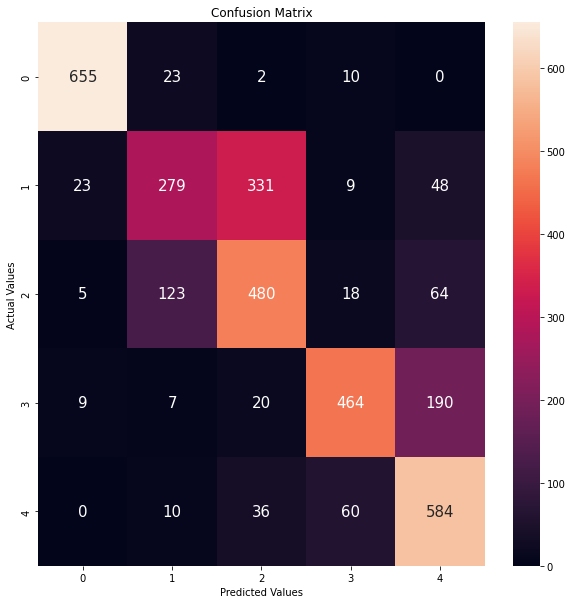

In [47]:
cm_df=plot_cm(model_1, testX, testy)

### transform to freq domain

In [48]:
X,y=extract_xy_time(main)


In [49]:
def time_to_freq(X,limit=90):
    from scipy import signal
    X = X.reshape(11500,178)
    X_transform = []
    for i in range(X.shape[0]):
        sf = X.shape[1]
        freqs, psd = signal.welch(X[i], sf, nperseg=sf)
        X_transform.append(psd[:limit])
    
    X_transform = np.array(X_transform)
    X_transform = X_transform.reshape(11500,limit,1)
    return X_transform


In [50]:
X_transform = time_to_freq(X)

In [51]:
trainX, testX, trainy, testy = split(X_transform,y)

In [46]:
model_2,history = lstm(trainX, testX, trainy, testy)

Epoch 1/100
161/161 [==============================] - 14s 74ms/step - loss: 1.2815 - accuracy: 0.4258 - val_loss: 1.0933 - val_accuracy: 0.5007
Epoch 2/100
161/161 [==============================] - 12s 74ms/step - loss: 0.9805 - accuracy: 0.5524 - val_loss: 0.8961 - val_accuracy: 0.5841
Epoch 3/100
161/161 [==============================] - 12s 74ms/step - loss: 0.8505 - accuracy: 0.5965 - val_loss: 0.7793 - val_accuracy: 0.6207
Epoch 4/100
161/161 [==============================] - 11s 71ms/step - loss: 0.7602 - accuracy: 0.6394 - val_loss: 0.7773 - val_accuracy: 0.6448
Epoch 5/100
161/161 [==============================] - 12s 74ms/step - loss: 0.7216 - accuracy: 0.6583 - val_loss: 0.7304 - val_accuracy: 0.6481
Epoch 6/100
161/161 [==============================] - 12s 74ms/step - loss: 0.6955 - accuracy: 0.6724 - val_loss: 0.6515 - val_accuracy: 0.6852
Epoch 7/100
161/161 [==============================] - 12s 74ms/step - loss: 0.6575 - accuracy: 0.6877 - val_loss: 0.6509 - val_ac

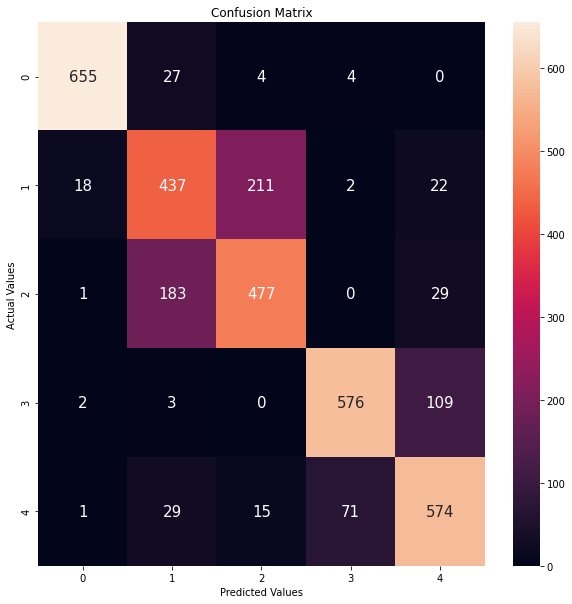

In [49]:
cm_df=plot_cm(model_2, testX, testy)

### Change from 5 classes to 3 classes:
### New class 1: Seizure, class 2: Tumor, Class 3: healthy

In [52]:
X,y = extract_xy_time(main)

In [53]:
def convert_class5to3(y):    
    new_class = []
    for i in y.reshape(y.shape[0]):
        if i == 5 or i == 4  :
            new_class.append(3)
        elif i == 2 or i == 3:
            new_class.append(2)
        else:
            new_class.append(1)
    new_class = np.array(new_class)
    return new_class       

In [54]:
y_new = convert_class5to3(y)

In [55]:
X_transform=time_to_freq(X)

In [56]:
trainX,testX,trainy,testy = split(X_transform,y_new)

In [57]:
trainy.shape

(8050, 3)

In [58]:
%%time 
model_3,history_3 = lstm(trainX,testX,trainy,testy)

Epoch 1/100
161/161 [==============================] - 4s 15ms/step - loss: 0.7159 - accuracy: 0.6776 - val_loss: 0.5118 - val_accuracy: 0.7906
Epoch 2/100
161/161 [==============================] - 2s 13ms/step - loss: 0.5007 - accuracy: 0.8040 - val_loss: 0.4049 - val_accuracy: 0.8431
Epoch 3/100
161/161 [==============================] - 2s 12ms/step - loss: 0.3921 - accuracy: 0.8517 - val_loss: 0.3282 - val_accuracy: 0.8766
Epoch 4/100
161/161 [==============================] - 2s 11ms/step - loss: 0.3496 - accuracy: 0.8730 - val_loss: 0.3276 - val_accuracy: 0.8856
Epoch 5/100
161/161 [==============================] - 2s 12ms/step - loss: 0.3223 - accuracy: 0.8825 - val_loss: 0.3397 - val_accuracy: 0.8655
Epoch 6/100
161/161 [==============================] - 2s 12ms/step - loss: 0.3034 - accuracy: 0.8923 - val_loss: 0.2806 - val_accuracy: 0.8954
Epoch 7/100
161/161 [==============================] - 2s 13ms/step - loss: 0.3015 - accuracy: 0.8917 - val_loss: 0.2768 - val_accuracy:

161/161 [==============================] - 3s 19ms/step - loss: 0.1294 - accuracy: 0.9542 - val_loss: 0.1125 - val_accuracy: 0.9594
Epoch 58/100
161/161 [==============================] - 3s 16ms/step - loss: 0.1219 - accuracy: 0.9550 - val_loss: 0.1237 - val_accuracy: 0.9534
Epoch 59/100
161/161 [==============================] - 3s 17ms/step - loss: 0.1279 - accuracy: 0.9530 - val_loss: 0.1014 - val_accuracy: 0.9606
Epoch 60/100
161/161 [==============================] - 2s 14ms/step - loss: 0.1215 - accuracy: 0.9558 - val_loss: 0.1079 - val_accuracy: 0.9586
Epoch 61/100
161/161 [==============================] - 3s 18ms/step - loss: 0.1164 - accuracy: 0.9563 - val_loss: 0.1023 - val_accuracy: 0.9626
Epoch 62/100
161/161 [==============================] - 3s 19ms/step - loss: 0.1124 - accuracy: 0.9542 - val_loss: 0.1127 - val_accuracy: 0.9580
Epoch 63/100
161/161 [==============================] - 3s 17ms/step - loss: 0.1139 - accuracy: 0.9566 - val_loss: 0.1051 - val_accuracy: 0.960

In [144]:
#model_3.save('model_3_lstm_freq')

INFO:tensorflow:Assets written to: model_3_lstm_freq\assets


INFO:tensorflow:Assets written to: model_3_lstm_freq\assets


In [189]:
model_3_loaded = keras.models.load_model('model_3_lstm_freq')

In [193]:
from keras_sequential_ascii import keras2ascii
keras2ascii(model_3_loaded)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     90    1
                LSTM   LLLLL -------------------     40800    79.7%
                tanh   #####         100
             Dropout    | || -------------------         0     0.0%
                       #####         100
               Dense   XXXXX -------------------     10100    19.7%
                relu   #####         100
               Dense   XXXXX -------------------       303     0.6%
             softmax   #####           3


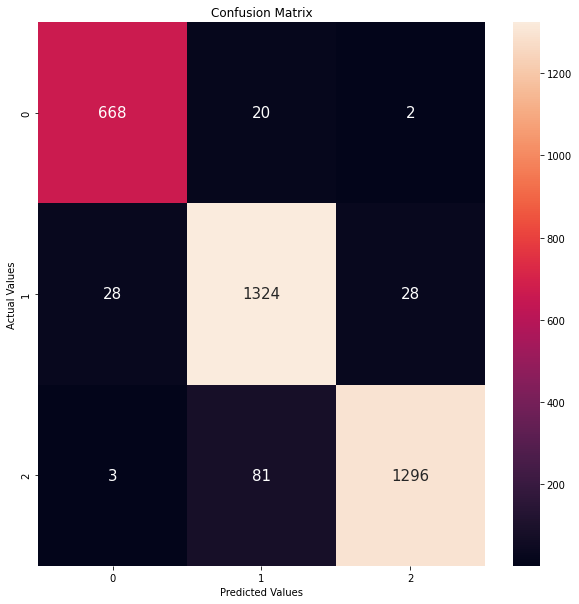

In [59]:
cm_df=plot_cm(model_3, testX, testy)

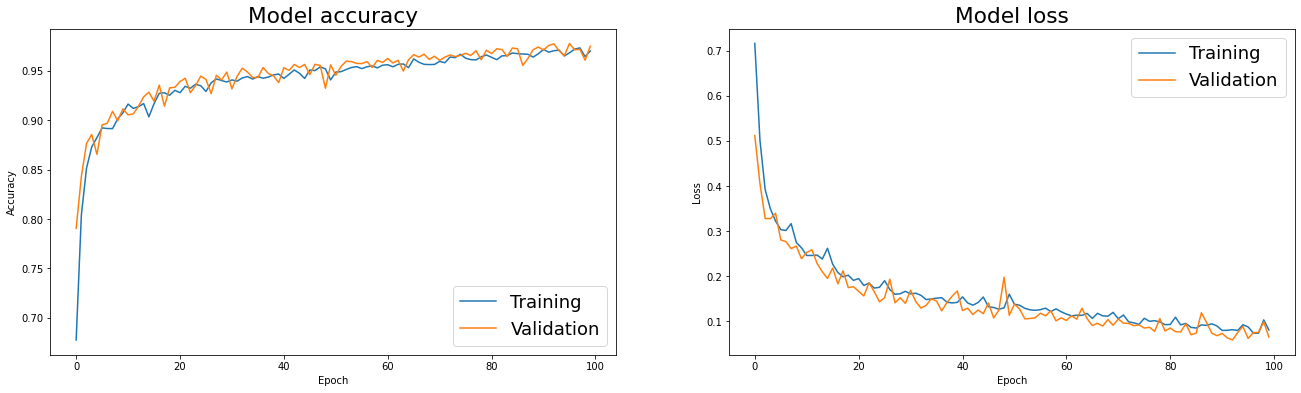

In [60]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(history_3.history['accuracy'], label = 'Training')
ax[0].plot(history_3.history['val_accuracy'], label = 'Validation')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(history_3.history['loss'], label = 'Training')
ax[1].plot(history_3.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

In [230]:
# using time series as input

In [61]:
X,y = extract_xy_time(main)

In [62]:
y_new = convert_class5to3(y)

In [63]:
trainX,testX,trainy,testy = split(X,y_new)

In [64]:
%%time 
model_XX,history_XX = lstm(trainX,testX,trainy,testy)

Epoch 1/100
161/161 [==============================] - 5s 22ms/step - loss: 0.7017 - accuracy: 0.6906 - val_loss: 0.4340 - val_accuracy: 0.8429
Epoch 2/100
161/161 [==============================] - 3s 21ms/step - loss: 0.4884 - accuracy: 0.8255 - val_loss: 0.3696 - val_accuracy: 0.8624
Epoch 3/100
161/161 [==============================] - 3s 20ms/step - loss: 0.4426 - accuracy: 0.8364 - val_loss: 0.3297 - val_accuracy: 0.8796
Epoch 4/100
161/161 [==============================] - 3s 21ms/step - loss: 0.3959 - accuracy: 0.8585 - val_loss: 0.3449 - val_accuracy: 0.8754
Epoch 5/100
161/161 [==============================] - 3s 20ms/step - loss: 0.4694 - accuracy: 0.8227 - val_loss: 0.4690 - val_accuracy: 0.8128
Epoch 6/100
161/161 [==============================] - 3s 19ms/step - loss: 0.4394 - accuracy: 0.8376 - val_loss: 0.3571 - val_accuracy: 0.8725
Epoch 7/100
161/161 [==============================] - 4s 22ms/step - loss: 0.3691 - accuracy: 0.8662 - val_loss: 0.3066 - val_accuracy:

161/161 [==============================] - 4s 27ms/step - loss: 0.1195 - accuracy: 0.9561 - val_loss: 0.0845 - val_accuracy: 0.9670
Epoch 58/100
161/161 [==============================] - 4s 27ms/step - loss: 0.1171 - accuracy: 0.9605 - val_loss: 0.0925 - val_accuracy: 0.9637
Epoch 59/100
161/161 [==============================] - 4s 27ms/step - loss: 0.1146 - accuracy: 0.9574 - val_loss: 0.0965 - val_accuracy: 0.9627
Epoch 60/100
161/161 [==============================] - 4s 25ms/step - loss: 0.1115 - accuracy: 0.9614 - val_loss: 0.3026 - val_accuracy: 0.9062
Epoch 61/100
161/161 [==============================] - 4s 27ms/step - loss: 0.1321 - accuracy: 0.9533 - val_loss: 0.1267 - val_accuracy: 0.9516
Epoch 62/100
161/161 [==============================] - 4s 26ms/step - loss: 0.1260 - accuracy: 0.9563 - val_loss: 0.0818 - val_accuracy: 0.9682
Epoch 63/100
161/161 [==============================] - 5s 30ms/step - loss: 0.1238 - accuracy: 0.9540 - val_loss: 0.0800 - val_accuracy: 0.971

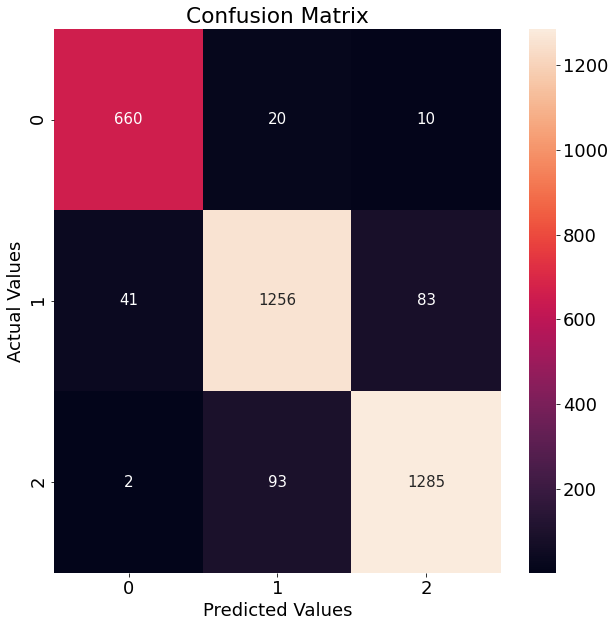

In [236]:
cm_df=plot_cm(model_XX, testX, testy)

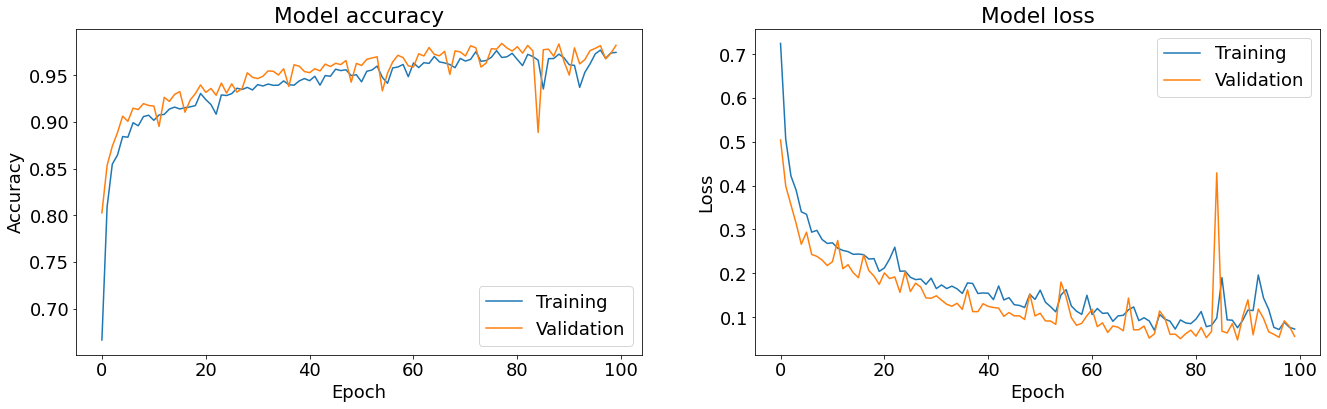

In [238]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(history_XX.history['accuracy'], label = 'Training')
ax[0].plot(history_XX.history['val_accuracy'], label = 'Validation')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(history_XX.history['loss'], label = 'Training')
ax[1].plot(history_XX.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

In [235]:
# Trying out other model

In [65]:
def convlstm(trainX, testX, trainy, testy):
    from keras.layers import ConvLSTM2D
    if trainX.shape[1] == 178:

        newtrainX =np.delete(trainX,[175,176,177],axis=1)
        newtestX = np.delete(testX,[175,176,177],axis=1)

    else:
        newtrainX = trainX
        newtestX = testX

    # define model
    verbose, epochs, batch_size = 1, 100, 64
    n_timesteps, n_features, n_outputs = newtrainX.shape[1], newtrainX.shape[2], trainy.shape[1]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    n_steps, n_length = 5, int(newtrainX.shape[1]/5)

    newtrainX = newtrainX.reshape((newtrainX.shape[0], n_steps, 1, n_length, n_features))
    newtestX = newtestX.reshape((newtestX.shape[0], n_steps, 1, n_length, n_features))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    #early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
    
    history = model.fit(newtrainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,
                        validation_data=(newtrainX, trainy))
    # evaluate model
    score = model.evaluate(newtestX, testy, batch_size=batch_size, verbose=0)
    print('Accuracy',score[1])
    return model, history

In [264]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 33, 64)         50176     
                                                                 
 dropout_3 (Dropout)         (None, 1, 33, 64)         0         
                                                                 
 flatten (Flatten)           (None, 2112)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               211300    
                                                                 
 dense_7 (Dense)             (None, 5)                 505       
                                                                 
Total params: 261,981
Trainable params: 261,981
Non-trainable params: 0
_________________________________________________________________


## Conclusion:
## Project should focus on 3 classes, predicting seizure and tumor
## frequency is better than time series

In [58]:
# testing out convlstm

In [66]:
X_transform=time_to_freq(X,limit =40)
trainX, testX, trainy, testy = split(X_transform,y_new)


In [67]:
%%time
model_4, history = convlstm(trainX, testX, trainy, testy)

Epoch 1/100
126/126 [==============================] - 11s 64ms/step - loss: 22.3803 - accuracy: 0.3152 - val_loss: 7.2875 - val_accuracy: 0.4599
Epoch 2/100
126/126 [==============================] - 8s 62ms/step - loss: 8.2793 - accuracy: 0.4035 - val_loss: 4.7366 - val_accuracy: 0.6027
Epoch 3/100
126/126 [==============================] - 8s 64ms/step - loss: 7.4415 - accuracy: 0.4520 - val_loss: 3.6697 - val_accuracy: 0.6089
Epoch 4/100
126/126 [==============================] - 10s 80ms/step - loss: 5.3529 - accuracy: 0.5120 - val_loss: 3.2220 - val_accuracy: 0.6379
Epoch 5/100
126/126 [==============================] - 14s 111ms/step - loss: 4.3877 - accuracy: 0.5394 - val_loss: 2.6024 - val_accuracy: 0.6029
Epoch 6/100
126/126 [==============================] - 16s 126ms/step - loss: 3.5616 - accuracy: 0.5867 - val_loss: 2.4143 - val_accuracy: 0.6624
Epoch 7/100
126/126 [==============================] - 12s 96ms/step - loss: 3.3299 - accuracy: 0.5955 - val_loss: 1.8398 - val_a

126/126 [==============================] - 11s 87ms/step - loss: 0.3826 - accuracy: 0.8743 - val_loss: 0.3179 - val_accuracy: 0.8853
Epoch 58/100
126/126 [==============================] - 12s 93ms/step - loss: 0.3934 - accuracy: 0.8742 - val_loss: 0.3664 - val_accuracy: 0.8871
Epoch 59/100
126/126 [==============================] - 11s 86ms/step - loss: 0.3619 - accuracy: 0.8832 - val_loss: 0.3060 - val_accuracy: 0.8957
Epoch 60/100
126/126 [==============================] - 11s 86ms/step - loss: 0.3639 - accuracy: 0.8815 - val_loss: 0.3179 - val_accuracy: 0.8918
Epoch 61/100
126/126 [==============================] - 9s 74ms/step - loss: 0.3465 - accuracy: 0.8836 - val_loss: 0.2909 - val_accuracy: 0.8942
Epoch 62/100
126/126 [==============================] - 7s 58ms/step - loss: 0.3376 - accuracy: 0.8891 - val_loss: 0.3189 - val_accuracy: 0.8912
Epoch 63/100
126/126 [==============================] - 7s 58ms/step - loss: 0.3324 - accuracy: 0.8917 - val_loss: 0.3178 - val_accuracy: 0

In [153]:
model_4.save('model_4_convlstm_freq')

INFO:tensorflow:Assets written to: model_4_convlstm_freq\assets


INFO:tensorflow:Assets written to: model_4_convlstm_freq\assets


In [142]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)

n_steps, n_length = 5, int(trainX.shape[1]/5)

newtestX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))

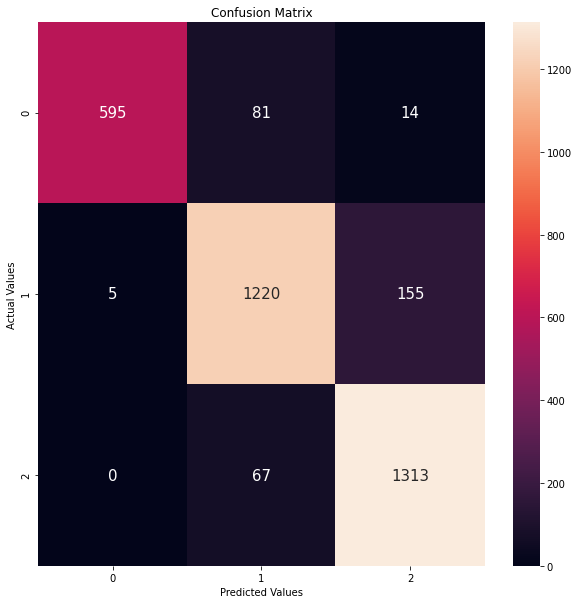

In [143]:
cm_df=plot_cm(model_4, newtestX, testy)